In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
script_directory = pathlib.Path("../2.train-VAE/utils/").resolve()
sys.path.insert(0, str(script_directory))
from betavae import BetaVAE, compile_vae, extract_latent_dimensions, weights
from optimize_utils import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "BetaVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 201.84761616721082, Val Loss: 383.7576497395833, Test Loss: 382.5198160807292
Epoch 2, Train Loss: 186.2223876953125, Val Loss: 365.1903483072917, Test Loss: 415.09648980034723
Epoch 3, Train Loss: 179.32298529326027, Val Loss: 461.6288655598958, Test Loss: 568.4002278645834
Epoch 4, Train Loss: 169.2826368645056, Val Loss: 588.703857421875, Test Loss: 643.8069118923611
Epoch 5, Train Loss: 162.1125193126166, Val Loss: 180.86756049262152, Test Loss: 192.54787868923611
Epoch 6, Train Loss: 159.75924418435167, Val Loss: 178.03389485677084, Test Loss: 184.45260959201389
Epoch 7, Train Loss: 151.54412495627332, Val Loss: 161.05002170138889, Test Loss: 165.41192626953125
Epoch 8, Train Loss: 148.41753202979245, Val Loss: 154.92068820529514, Test Loss: 151.62076144748264
Epoch 9, Train Loss: 144.0112157109958, Val Loss: 174.40599907769098, Test Loss: 176.41168891059027
Epoch 10, Train Loss: 138.25894429221083, Val Loss: 140.53568522135416, Test Loss: 140.6545206705729
Ep

In [5]:
# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [11]:
# Save training history
history = {
    'loss': train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

# Convert the history dictionary into a DataFrame
history_df = pd.DataFrame(history)

# Define the path for the CSV file
history_path = pathlib.Path("results/training_history.csv")

# Save the DataFrame to a CSV file
history_df.to_csv(history_path, index=False)

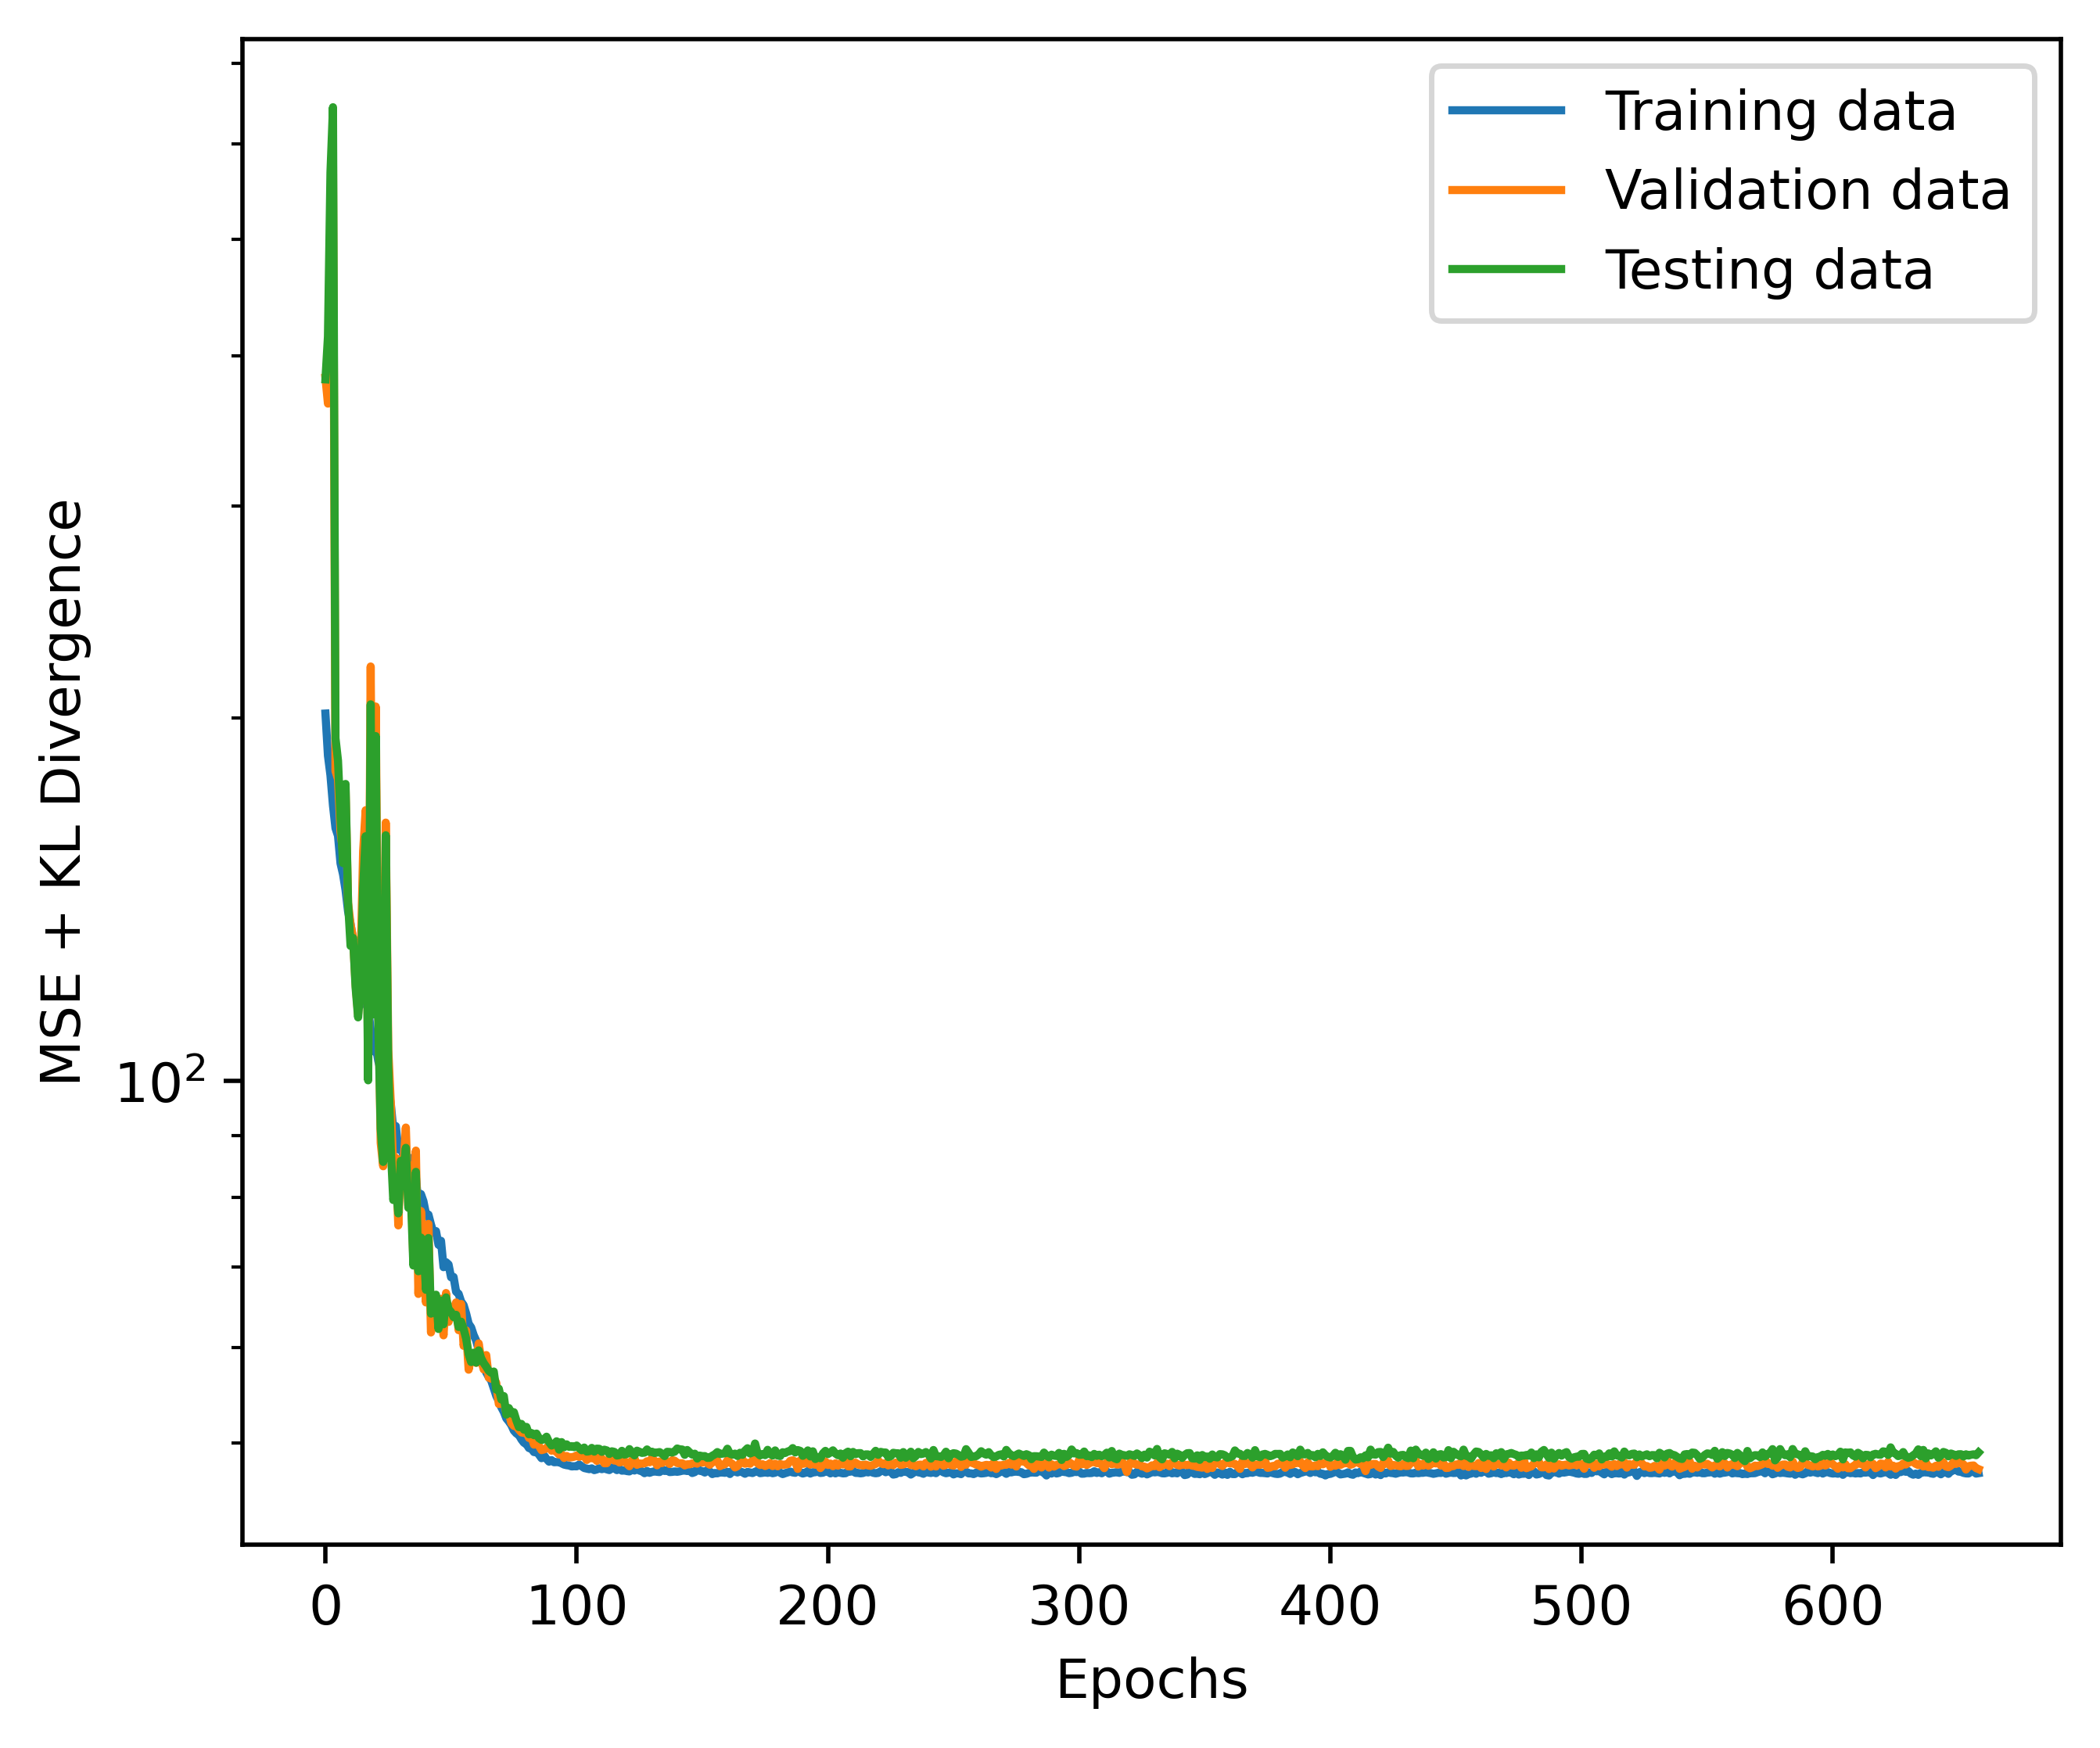

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(train_loss_history, label="Training data")
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

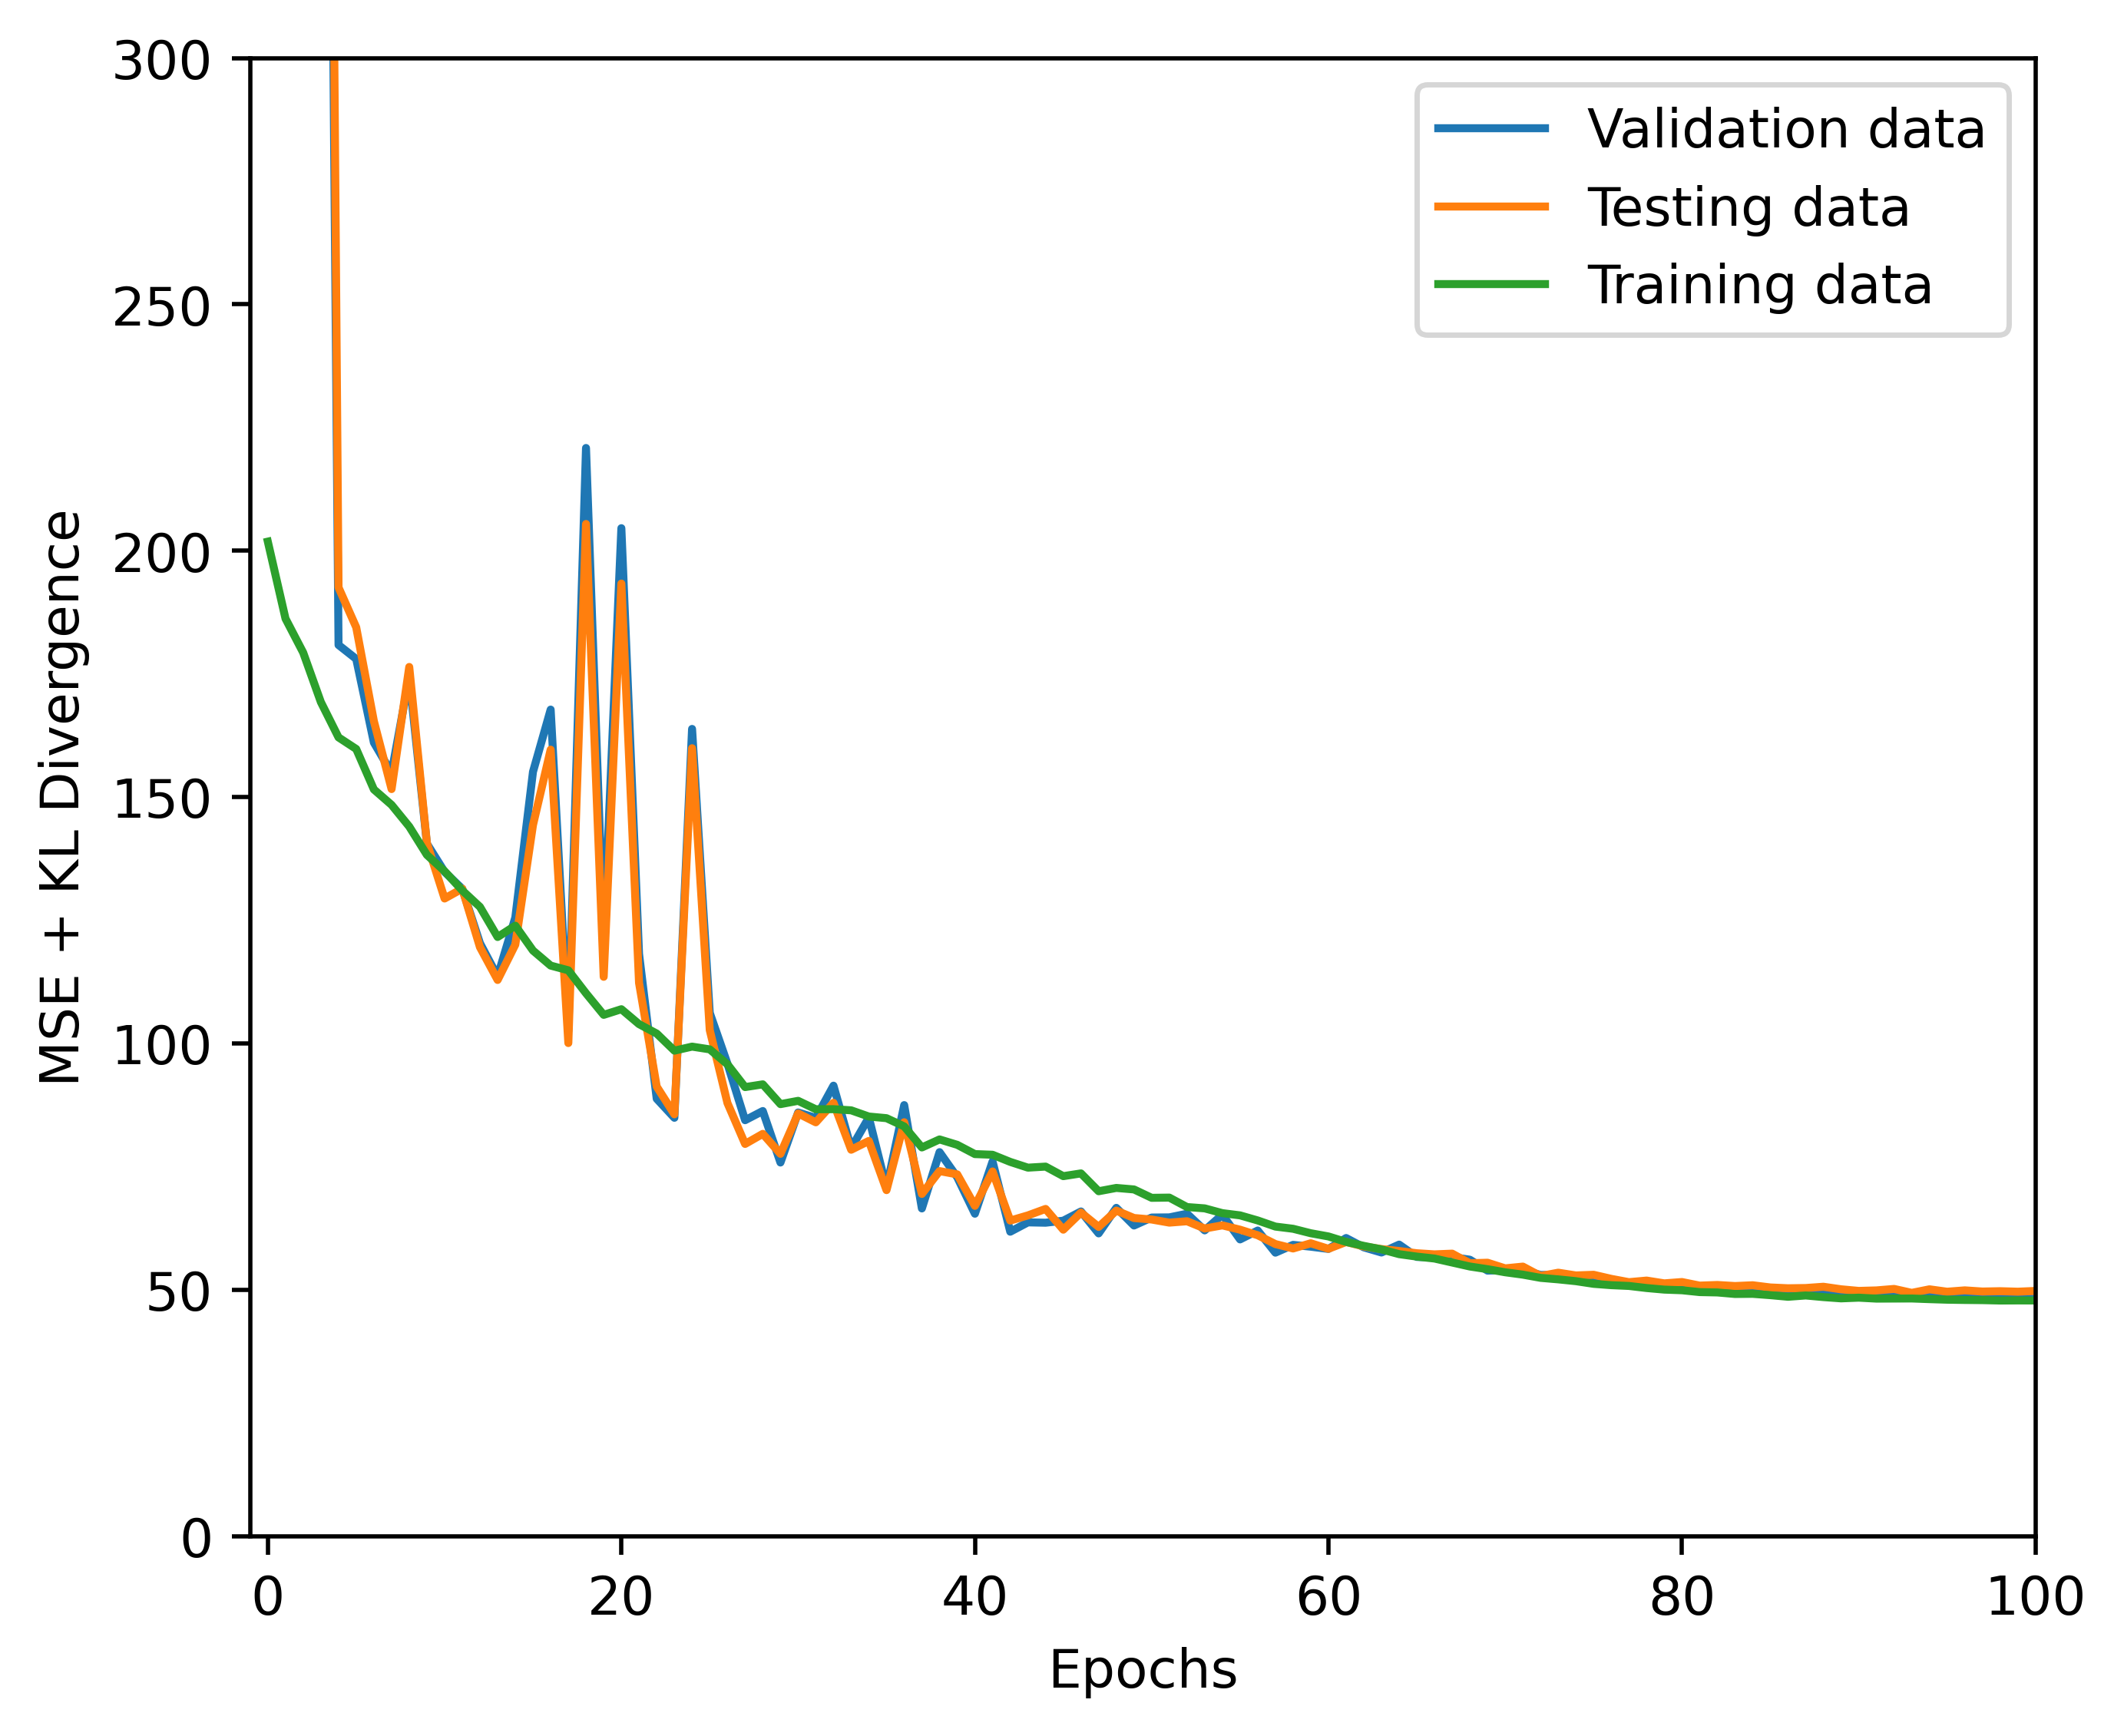

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,100)
plt.ylim(0,300)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

path = "./results/latent_df.parquet"

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata, path)
print(latent_df.head())

      ModelID    0         1    2    3         4    5    6         7    8  \
0  ACH-000361  0.0  3.255387  0.0  0.0  5.045087  0.0  0.0  1.408986  0.0   
1  ACH-000976  0.0  2.218811  0.0  0.0  4.416852  0.0  0.0  2.040887  0.0   
2  ACH-000279  0.0  4.556664  0.0  0.0  6.355830  0.0  0.0  1.283698  0.0   
3  ACH-000515  0.0  3.391813  0.0  0.0  5.268193  0.0  0.0  1.179573  0.0   
4  ACH-001523  0.0  4.137980  0.0  0.0  5.661453  0.0  0.0  2.405638  0.0   

   ...        10   11   12   13        14        15        16        17   18  \
0  ...  0.690946  0.0  0.0  0.0  0.454656  4.352063  0.683276  4.367734  0.0   
1  ...  1.356786  0.0  0.0  0.0  0.914360  3.289774  0.749229  3.299878  0.0   
2  ...  2.364471  0.0  0.0  0.0  1.205056  5.896776  2.171388  6.194820  0.0   
3  ...  2.479507  0.0  0.0  0.0  1.269716  4.615336  2.053122  4.988557  0.0   
4  ...  0.512005  0.0  0.0  0.0  1.034038  5.856451  0.608120  5.399203  0.0   

    19  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[

In [10]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train"
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data, path)